In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot


import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

## Make data

In [2]:
n_verts = 100
labels_sbm = n_verts * [0] + n_verts * [1]
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate SBMs from parameters
undirected_sbm = sbm(2 * [n_verts], P)
directed_sbm = sbm(2 * [n_verts], P, directed=True)

## Using graspologic ZG(2) method

In [3]:
from graspologic.embed import select_dimension
select_dimension(undirected_sbm)

([2, 4], [60.040654885507344, 11.571250884605346])

## Example use of using sklean minka estimation

In [4]:
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

def minka(X):
    n_components = 'mle'
    n_samples = X.shape[0]
    U, S, Vt = linalg.svd(X, full_matrices=False)
    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = svd_flip(U, Vt)

    components_ = Vt

    # Get variance explained by singular values
    explained_variance_ = (S ** 2) / (n_samples - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var
    singular_values_ = S.copy()  # Store the singular values.

    # Postprocess the number of components required
    if n_components == 'mle':
        n_components = \
            _infer_dimension(explained_variance_, n_samples)
    return n_components

In [5]:
minka(undirected_sbm)

3

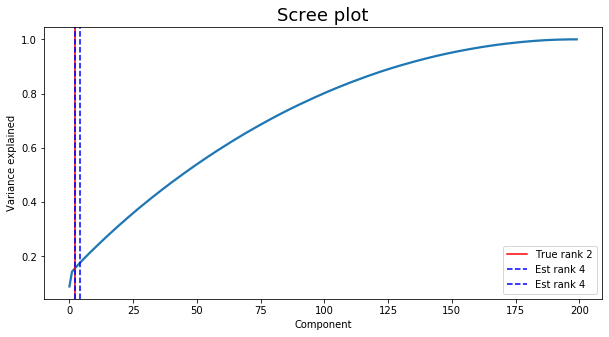

In [6]:
from graspologic.plot import screeplot
screeplot(undirected_sbm)
plt.axvline(2, label='True rank {}'.format(2), color='red')
plt.axvline(4, label='Est rank {}'.format(4), color='blue', ls='--')
plt.axvline(2, label='Est rank {}'.format(4), color='blue', ls='--')
plt.legend()

In [7]:
import scipy
k = int(np.ceil(np.log2(np.min(undirected_sbm.shape))))
D = scipy.sparse.linalg.svds(A=undirected_sbm, k=k, return_singular_vectors=False)
D = np.sort(D)[::-1]

In [8]:
D

array([98.90493025, 60.04065489, 12.11399685, 11.57125088, 11.23993611,
       10.94278271, 10.67831547, 10.43480617])

# Simulation 1

Procedure of the experiment

***

1.&emsp; Create a matrix $M$ from random distribution ($\mu = 0, \sigma = 1$) that is 20x20

2.&emsp; We want to have independent columns of $M$ and therefore use an $U \Sigma V^T = svd(M) $ in order to get a basis matrix which has these properties between our columns 

3.&emsp;  With this we know that the first colun of $U$ has hte largest singular value and therefore the largest variance. 

4.&emsp; We then add linear combinations of our columns from $U$ as columns to the $U$ matrix. This is done in the following way let us consider for example making a of one dependent column to add to our matrix(we do 15 of these in this experiment).

5.&emsp; We use uniform random distribution to choose 5 columns from $U$. These will be stored in $g_1, ...g_5$

6.&emsp; We use random uniform between $[0, 1)$ to generate 5 coefficients to each of these columns store in $c_1, ..., c_5$

7.&emsp; for one new dependent column made of five independent columns and random coefficients we do $$ h_ i = \sum_{n = 1}^5 g_n c_n$$

8.&emsp; Do this for 15 times total. Then concatonate this to your U matrix such that we have $$Y = [U_1, ..., U_{20}, h_1, ..., h_{15}]$$

9.&emsp; The previous step was mostly just done to ensure that even if ZG or Minka were not to choose the the correct number of dimensions as 1 it would then be forced to choose it as 20 because the rest of the columns of $Y$ do not have any variance that would need to be capture in SVD. 

10.&emsp; Next we have our pertubations matrix $P$ which is 20 x 35 and the values of $\mu, \sigma$ depend on which part of the experiment we are on. $$ P = \begin{bmatrix} normal(\mu, \sigma) & \dots \\ \vdots & \ddots & \\ \end{bmatrix}$$

11.&emsp; Thus our pertubed matrix $Y_P = Y + P$

12.&emsp; We then do experiments testing out the sensitivity and stability of ZG and Minka are to changes in how large the perturbations which we control by $\mu, \sigma$

13.&emsp; The first test is slowly increasing $\sigma$, the second test is with slowly increasing $\mu, \sigma = 0$ and then third test is with slowly increasing $\mu, \sigma = 1$.  At each new value of $\sigma$ or $\mu$, 50 trials are ran and the average of the trial is graphed. For minka the simple average of the all 50 trials is easy. For ZG since two dimensions are given the average dimension of what ZG chooses as the first dimension and average dimension of second dimension are computed and thus from this two means  for ZG are returned. One for the first chosen and second chosen dimension. 


In [9]:
import random 
def make_linear_combos(U):
    vecs = np.zeros((U.shape[0], 15))
    lin_comb = 5
    for i in range(vecs.shape[1]):
        coefs = np.random.rand(lin_comb,1)
        inds = np.random.randint(0,U.shape[1], lin_comb)
        for j in range(lin_comb):
            vecs[:, i] += U[:, inds[j]] * coefs[j]
    return vecs
    

In [10]:
def make_corrupted_basis(size =20):    
    X_sim = np.random.normal(0, 1, (size, size))
    U, S, Vt = linalg.svd(X_sim)
    # this has rank 10 so we would expect that d chose to be 10 with superfluous parts on matrix
    uncorrupted_basis = U[:, :int(size/2)]
    v = make_linear_combos(U)
    corrupted_basis = np.hstack((uncorrupted_basis, v ))
    return corrupted_basis

In [11]:
# pertub matrix meaning that we have X + Delta where delta is random noise
# noise in this case will be normal 
def perturb(X, mu, std):
    perturb = np.random.normal(mu, std, (X.shape[0], X.shape[1]))
    return X + perturb

In [12]:
corrupted_basis = make_corrupted_basis()

In [13]:
select_dimension(corrupted_basis)[0]

[1, 3]

In [14]:
minka(corrupted_basis)

1

The experiment is as follows we start at 0 perturbation where both minka and ZG(2) should give us the same answer. Then we shall continue to perturb the matrix with larger and larger mu, std, and mu and std(maybe?). We shall graphically see which one changes with more perturbations

In [15]:
simulation_size = 50

### std

In [16]:
stds = np.arange(0, 1.1, .1)
std_rem = []
mus = np.arange(0, 11, 1)
corrupted_basis = make_corrupted_basis()
m_est = []
m_est_var = []
zg_est = []
zg_est_var = []
for i in range(stds.shape[0]):
    zg_helper = []
    minka_helper = []
    for j in range(simulation_size):
        perturbed = perturb(corrupted_basis, 0, stds[i])
        zg_helper.append(select_dimension(perturbed)[0])
        minka_helper.append(minka(perturbed))
    if np.asarray(zg_helper).shape != (simulation_size, 2):
        std_rem.append(stds[i])
        continue        
    m_est.append(np.mean(np.asarray(minka_helper)))    
    zg_est.append([np.mean(np.asarray(zg_helper)[:, 0]), np.mean(np.asarray(zg_helper)[:, 1]) ])
    m_est_var.append(np.std(np.asarray(minka_helper)))
    zg_est_var.append([np.std(np.asarray(zg_helper)[:, 0]), np.std(np.asarray(zg_helper)[:, 1]) ])
zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)

In [17]:
stds = list(stds)
for i in range(len(std_rem)):
    stds.remove(std_rem[i])

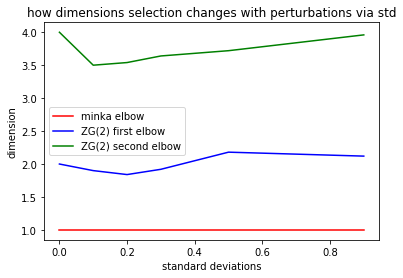

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(stds, m_est,c = 'red', label = 'minka elbow')
ax.plot(stds, zg_est[:, 0],c = 'blue', label = 'ZG(2) first elbow')
ax.plot(stds, zg_est[:, 1],c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via std")
ax.set(xlabel = "standard deviations", ylabel="dimension")
plt.show()


Forgot to display error bars, these are one std

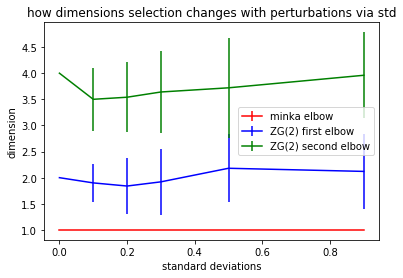

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.errorbar(stds, m_est, yerr=m_est_var, c = 'red', label = 'minka elbow')
ax.errorbar(stds, zg_est[:, 0], yerr=np.asarray(zg_est_var)[:, 0], c = 'blue', label = 'ZG(2) first elbow')
ax.errorbar(stds, zg_est[:, 1], yerr=np.asarray(zg_est_var)[:, 1], c = 'green', label = 'ZG(2) second elbow')
plt.title("how dimensions selection changes with perturbations via std")
ax.set(xlabel = "standard deviations", ylabel="dimension")
ax.legend()

### mu

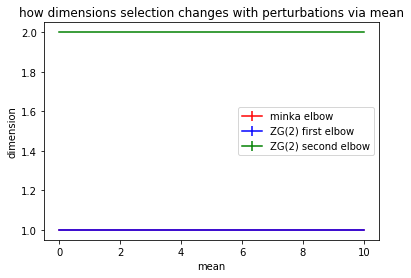

In [27]:
import matplotlib.pyplot as plt

stds = np.arange(0, 1.1, .1)
std_rem = []
mus = np.arange(0, 11, 1)
mus_rem = []
corrupted_basis = make_corrupted_basis()
m_est = []
m_est_var = []
zg_est = []
zg_est_var = []
for i in range(mus.shape[0]):
    zg_helper = []
    minka_helper = []
    for j in range(simulation_size):
        perturbed = perturb(corrupted_basis, mus[i], 0)
        zg_helper.append(select_dimension(perturbed)[0])
        minka_helper.append(minka(perturbed))
    if np.asarray(zg_helper).shape != (simulation_size, 2):
        mus_rem.append(mus[i])
        continue        
    m_est.append(np.mean(np.asarray(minka_helper)))    
    zg_est.append([np.mean(np.asarray(zg_helper)[:, 0]), np.mean(np.asarray(zg_helper)[:, 1]) ])
    m_est_var.append(np.std(np.asarray(minka_helper)))
    zg_est_var.append([np.std(np.asarray(zg_helper)[:, 0]), np.std(np.asarray(zg_helper)[:, 1]) ])
zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)

mus = list(mus)
for i in range(len(mus_rem)):
    mus.remove(mus_rem[i])
    

fig, ax = plt.subplots()
ax.errorbar(mus, m_est, yerr=m_est_var, c = 'red', label = 'minka elbow')
ax.errorbar(mus, zg_est[:, 0], yerr=np.asarray(zg_est_var)[:, 0], c = 'blue', label = 'ZG(2) first elbow')
ax.errorbar(mus, zg_est[:, 1], yerr=np.asarray(zg_est_var)[:, 1], c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via mean")
ax.set(xlabel = "mean", ylabel="dimension")
plt.show()

### mu and std = 1

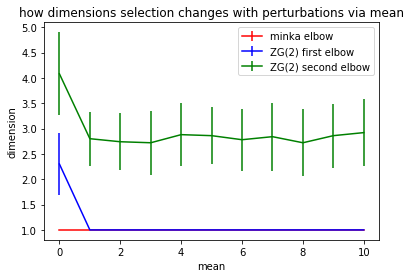

In [28]:
import matplotlib.pyplot as plt

stds = np.arange(0, 1.1, .1)
std_rem = []
mus = np.arange(0, 11, 1)
mus_rem = []
corrupted_basis = make_corrupted_basis()
m_est = []
m_est_var = []
zg_est = []
zg_est_var = []
for i in range(mus.shape[0]):
    zg_helper = []
    minka_helper = []
    for j in range(simulation_size):
        perturbed = perturb(corrupted_basis, mus[i], 1)
        zg_helper.append(select_dimension(perturbed)[0])
        minka_helper.append(minka(perturbed))
    if np.asarray(zg_helper).shape != (simulation_size, 2):
        mus_rem.append(mus[i])
        continue        
    m_est.append(np.mean(np.asarray(minka_helper)))    
    zg_est.append([np.mean(np.asarray(zg_helper)[:, 0]), np.mean(np.asarray(zg_helper)[:, 1]) ])
    m_est_var.append(np.std(np.asarray(minka_helper)))
    zg_est_var.append([np.std(np.asarray(zg_helper)[:, 0]), np.std(np.asarray(zg_helper)[:, 1]) ])
zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)

mus = list(mus)
for i in range(len(mus_rem)):
    mus.remove(mus_rem[i])
    

fig, ax = plt.subplots()
ax.errorbar(mus, m_est, yerr=m_est_var, c = 'red', label = 'minka elbow')
ax.errorbar(mus, zg_est[:, 0], yerr=np.asarray(zg_est_var)[:, 0], c = 'blue', label = 'ZG(2) first elbow')
ax.errorbar(mus, zg_est[:, 1], yerr=np.asarray(zg_est_var)[:, 1], c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via mean")
ax.set(xlabel = "mean", ylabel="dimension")
plt.show()

What we have just shown above is the stability of ZG compared to minka. Minka appears to always get the Rank (1) correct. and does not suffer much from variation. ZG seems to be a little more sensitive to standard deviation perturbations more than mean. 

# Simulation 2

